In [1]:
import numpy as np
import qiskit
from qiskit.circuit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram

from utils.phase_estimator import get_phase_estimation
from utils.grover import GroverSolver
from utils.counting import get_count
from utils.misc import execute_circ,simulator

# Phase Estimation

0.3984375


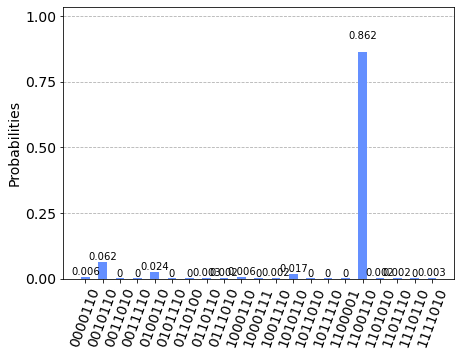

In [2]:
from utils.phase_estimator import get_phase_estimation
from qiskit.circuit import QuantumCircuit

t = 7
theta = 0.4 # 0 < theta < 1

theta = 2*np.pi * theta
unitary = QuantumCircuit(1)
unitary.p(theta,unitary.qubits)

circ = QuantumCircuit(1)
circ.x(0)

sol = get_phase_estimation(circ,unitary,t)

counts = sol['counts']

print(sol['phase'])
plot_histogram(counts)

# Grover

0.9873046875


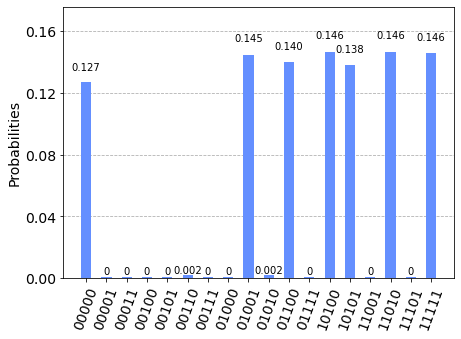

In [3]:
items = [12,[1,0,0,1],'11010','10101','0','11111','10100']
# items = [*range(5)]+[7]
# items = [0,1]

sol = GroverSolver(items)
circ, states = sol['circuit'], sol['states']
circ.measure_all()

counts = execute_circ(circ,simulator).get_counts(circ)
print(sum([counts[''.join(map(str,state))] for state in states])/sum(counts.values()))#total proba of chosen items

plot_histogram(counts)

# Quantum Counting

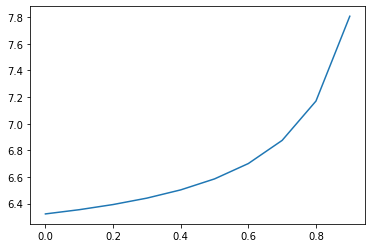

In [4]:
from matplotlib import pyplot as plt

m = 5 # m bits of accuracy
t = lambda eps: m + np.log2(2+1/(2*eps))

eps = np.linspace(0.1,1,10)
plt.plot(1-eps,t(eps)) #xaxis: success proba, yaxis: t (counting qubits)

In [76]:
success_chance = 0.7
m = 4

# items = [*range(7)]
items = [12,[1,0,0,1],'1101','1010','0']
items = [0,1,2,3,5]
# items = [0]

sol = GroverSolver(items)
grover_op = sol['grover_op']

no_of_solutions, theta, err = get_count(m,success_chance,grover_op)

# It gives pi +/- (theoretical) theta bcs we are using -U_s in Grover. The plus/minus comes from the positive/negative eigenvalue
theta = abs(np.pi-theta)
print('theta: ', theta/np.pi,'pi')

no_of_solutions = round(no_of_solutions)

no_of_solutions

t:  6 n:  4
theta:  0.37499999999999983 pi


5

# Refind Items

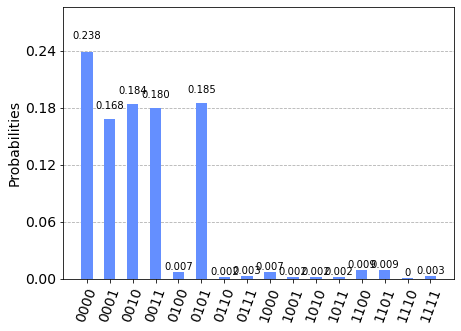

In [77]:
n = 4
t = round(0.5 * (np.pi/theta - 1))
circ = QuantumCircuit(n)
circ.h(circ.qubits)
for _ in range(t):
    circ.append(grover_op.to_gate(),circ.qubits)

circ.measure_all()

counts = execute_circ(circ,simulator).get_counts(circ)

plot_histogram(counts)